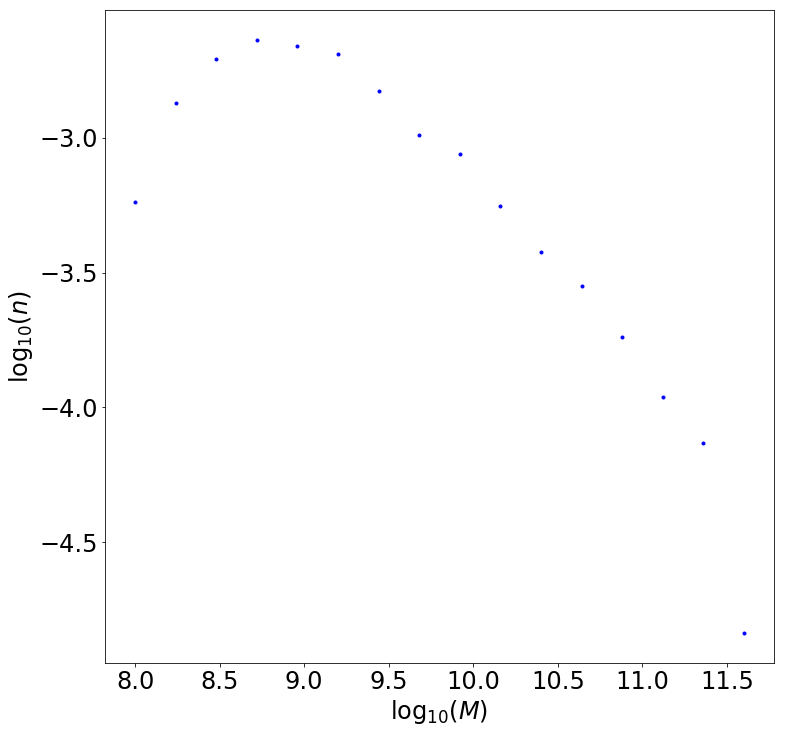

In [1]:
import numpy as np
from astropy import stats
from numpy.polynomial import Polynomial
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


'''Function calculating the volume'''


V = lambda x: 4.67e-5/3 * ( cosmo.comoving_distance(x)**3 - cosmo.comoving_distance(2)**3  )

'''Clean up of the catalogue'''


data = pd.read_csv('data.txt', sep='\s+', comment='#')
Hmag, redshift, Mmed, Seq = [], [], [], []
mag = data['Hmag']; z = data['zbest']; Pflag = data['PhotFlag']
Sflag = data['StarFlag']; AGNflag = data['AGNFlag']
for i in range(len(data['Seq'])):
    if mag.loc[i] < 27 and z.loc[i] >2 and z.loc[i] < 3 and Pflag.loc[i] == 0 and Sflag.loc[i] == 0 and AGNflag.loc[i] == 0:
        Hmag.append(mag.loc[i])
        redshift.append(z.loc[i])
        Mmed.append(data['M_med'].loc[i]) 
        Seq.append(data['Seq'].loc[i])
        
'''Creation galaxy bins'''


logMmed   = np.log10( np.array(Mmed) )
bins      = np.arange(8, 11.8, 0.2)
digitized = np.digitize(logMmed, bins) #bins 16+17+18 = 1 bin   


'''Finding z max'''


Hmag_max, redshift_max, corr = [], [], []
for i in range(len(Hmag)):
    Hmag1 = 0
    u = 0.1
    while Hmag1 <= 27:
        z1 = redshift[i] + u
        Hmag1 = - 2.5 * np.log10( (1+z1)/(1+redshift[i]) * cosmo.luminosity_distance(redshift[i])**2/cosmo.luminosity_distance(z1)**2 ) + Hmag[i]
        if z1 < 3:
            u += 0.1
        else:
            break
    Hmag_max.append(Hmag1)
    redshift_max += [z1] if z1 <= 3 else [3]
    corr.append( V(3)/V(redshift_max[i]) )
    #print(Seq[i], Hmag[i], redshift[i], Hmag_max[i], redshift_max[i], corr[i])

    
'''Plotting the data'''


corr = np.array(corr)
Vtot = 1833060.8393176936

count = []; p_vmax = []
for i in range(1, 16):
    count.append( sum( corr[digitized == i] ) / Vtot / 0.2 )
    p_vmax += [corr[digitized == i]]
count.append( sum( corr[digitized > 15] ) / Vtot / 0.6 )

X = np.linspace(8, 11.6, len(count))
a1, b1, c1 = np.polyfit(X, np.log10(count), deg=2)

fig = plt.figure(figsize=(12, 12))
frame = fig.add_subplot(1,1,1)
frame.plot(X, np.log10(count), 'b.')
frame.set_ylabel(r'$\log_{10}(n) $', fontsize=24)
frame.set_xlabel(r'$\log_{10}(M) $', fontsize=24)
plt.tick_params(axis='both', labelsize=24)

#frame.plot(X, a1*X**2+b1*X+c1)
show()

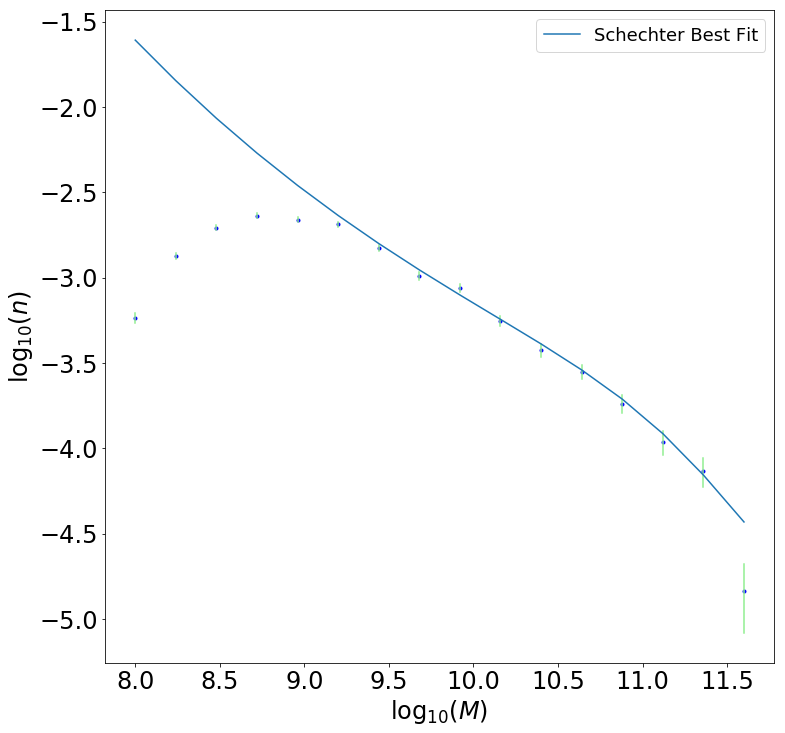

In [2]:
import math
LOG_10 = math.log(10)
e = 2.718
def log_schechter_fit(logM, log_M0=11.6, 
                      alpha=-1.14):
    schechter = -5.8
    schechter += 10**((alpha+1)*(logM-log_M0))
    schechter += e**(-pow(10,logM-log_M0))
    return schechter

count = np.array(count)
fig = plt.figure(figsize=(12, 12))
frame = fig.add_subplot(1,1,1)
frame.plot(X, np.log10(count), 'b.')
frame.set_ylabel(r'$\log_{10}(n) $', fontsize=24)
frame.set_xlabel(r'$\log_{10}(M) $', fontsize=24)
plt.tick_params(axis='both', labelsize=24)

updy = np.log10(count + (count*Vtot*0.2)**0.5/Vtot/0.2)
lody = np.log10(count - (count*Vtot*0.2)**0.5/Vtot/0.2)
for i in range(len(count)):
    frame.plot([X[i],X[i]], [lody[i], updy[i]], color='lightgreen')

frame.plot(X, log_schechter_fit(X), label='Schechter Best Fit')
plt.legend(prop={"size":18})
#plt.savefig('SchechterData.png')
show()